Implement PyTorch like API for MLPs. Implement visualization API (to visualize activation function saturations, gradients and gradient update rates).



In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [65]:
words = open("names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {s:idx + 1 for idx, s in enumerate(chars)}
stoi["."] = 0
itos = {idx: s for s, idx in stoi.items()}
block_size = 3

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
x, y = build_dataset(words)


torch.Size([228146, 3]) torch.Size([228146])


In [66]:
m = len(x)

rand_idxs = torch.randperm(m)
x = x[rand_idxs]
y = y[rand_idxs]
n1 = int(0.8 * m)
n2 = int(0.9 * m)

x_train = x[:n1]
y_train = y[:n1]
x_val = x[n1:n2]
y_val = y[n1:n2]
x_test = x[n2:]
y_test = y[n2:]

In [67]:
class Linear:
    def __init__(self, in_dim, out_dim, bias=True, device="cuda"):
        scale = 1 / (in_dim ** (0.5))
        self.w = torch.randn((in_dim, out_dim)) * scale
        self.b = torch.zeros(out_dim) if bias else None

        

    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        
        return self.out

    def parameters(self):
        params = [self.w] + ([] if self.b is None else [self.b])
        return params
class Embedding:
    def __init__(self, in_dim, out_dim, device="cuda"):
        self.c = torch.randn((in_dim, out_dim))

        

    def __call__(self, x):
        self.out = self.c[x]
        return self.out

    def parameters(self):
        return [self.c]
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps=1e-5, device="cuda"):
        self.momentum =  momentum
        self.eps = eps
        self.train = True

        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)

        self.mean_running = torch.zeros(dim)
        self.var_running = torch.ones(dim)

        

    def __call__(self, x):
        if self.train:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.mean_running
            x_var = self.var_running
        
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gain * x_hat + self.bias

        if self.train:
            self.mean_running = (1 - self.momentum) * self.mean_running + self.momentum * x_mean
            self.var_running = (1 - self.momentum) * self.var_running + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gain, self.bias]

In [68]:
n_embed = 10
block_size = 3
n_fc1 = 100
n_fc2 = 100
vocab_size = 27
class MLP:
    def __init__(self):
        self.layers = [
            Embedding(in_dim=x_train.shape[0],out_dim=n_embed),

            Linear(in_dim=n_embed * block_size, out_dim=n_fc1, bias=False),
            BatchNorm1d(dim=n_fc1),
            Tanh(),

            Linear(in_dim=n_fc1, out_dim=n_fc2, bias=False),
            BatchNorm1d(dim=n_fc2),
            Tanh(),

            Linear(in_dim=n_fc2, out_dim=vocab_size, bias=False),
            BatchNorm1d(dim=vocab_size),
        ]

        self.apply_grads()

    def __call__(self, x):
        self.out = self.layers[0](x).view(-1, n_embed * block_size)

        for layer in self.layers[1: ]:
            self.out = layer(self.out)

        return self.out
    
    def parameters(self):
        params = [p for layer in self.layers for p in layer.parameters()]
        return params

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def apply_grads(self):
        for p in self.parameters():
            p.requires_grad = True

In [69]:
net = MLP()
out = net(x_train)
out.shape
batch_size = 32
rand_idx = torch.randint(0, x_train.shape[0], (batch_size, ))
x_batch, y_batch = x_train[rand_idx], y_train[rand_idx]

In [70]:
n_steps = 1000
batch_size = 32
lr = 0.1

model = MLP()
losses = []

for iter in range(n_steps):
    y_hat = model(x_batch)
    loss = F.cross_entropy(y_hat, y_batch)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    for p in model.parameters():
        p.data = p.data - lr * p.grad

print(f"loss (train): {loss.item()}")

loss (train): 0.39517906308174133


[]

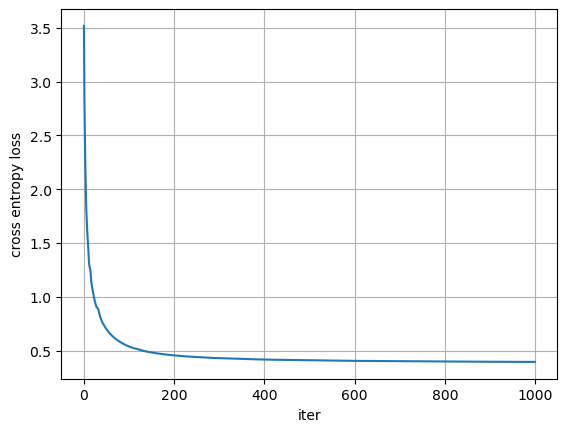

In [71]:

plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("cross entropy loss")
plt.grid()
plt.plot()

In [72]:
from tqdm import tqdm

def train_model(x_train, y_train, model, 
                n_steps=200000, batch_size=32, learn_rate=0.1):
    losses = []
    update_vs_data = []

    for iter in tqdm(range(n_steps)):
        rand_idx = torch.randint(0, x_train.shape[0], (batch_size, ))
        x_batch, y_batch = x_train[rand_idx], y_train[rand_idx]

        y_hat = model(x_batch)
        loss = F.cross_entropy(y_hat, y_batch)
        losses.append(loss.item())

        for layer in model.layers:
            layer.out.retain_grad()
        model.zero_grad()
        loss.backward()
        
        learn_rate = learn_rate if iter < (3 / 4 * n_steps) else learn_rate / 10
        for p in model.parameters():
            p.data = p.data - learn_rate * p.grad

        with torch.no_grad():
            ud_iter = []
            for p in model.parameters():
                ud = (learn_rate * p.grad).std() / p.data.std()
                ud = ud.log10().item()
                ud_iter.append(ud)

            update_vs_data.append(ud_iter)

    print(f"loss (train): {loss.item()}")

    return losses, update_vs_data

In [73]:
def plot_tanh_activations(model):
    plt.figure(figsize=(12, 4))
    legends = []
    for idx, layer in enumerate(model.layers[: -1]):
        if isinstance(layer, Tanh):
            tanh_act = layer.out

            sat_perc = ((tanh_act.abs() > 0.97).float().mean() * 100.0).item()
            tanh_act_mean = tanh_act.mean().item()
            tanh_act_std = tanh_act.std().item()
            layer_name = layer.__class__.__name__
            print(f"layer: {layer_name} \t mean: {round(tanh_act_mean, 3)} \t std: {round(tanh_act_std, 3)} \t sat_perc[%]: {round(sat_perc, 3)}")
            cnts, vals = torch.histogram(tanh_act.to(device="cpu"), density=True)
            
            plt.plot(vals[:-1].detach(), cnts.detach())
            legends.append(f"layer: {idx} ({layer_name})")

    plt.legend(legends);
    plt.title('distribution of activations for each layer');
    plt.show();


def plot_tanh_grads(model):
    plt.figure(figsize=(12, 4))
    legends = []
    for idx, layer in enumerate(model.layers[: -1]):
        if isinstance(layer, Tanh):
            tanh_act_grad = layer.out.grad

            tanh_act_mean = tanh_act_grad.mean().item()
            tanh_act_std = tanh_act_grad.std().item()
            layer_name = layer.__class__.__name__
            print(f"layer: {layer_name} \t mean: {round(tanh_act_mean, 6)} \t std: {round(tanh_act_std, 6)} \t")
            cnts, vals = torch.histogram(tanh_act_grad.to(device="cpu"), density=True)
            
            plt.plot(vals[:-1].detach(), cnts.detach())
            legends.append(f"layer: {idx} ({layer_name})")

    plt.legend(legends);
    plt.title('distribution of gradients for each layer');
    plt.show();

def plot_update_vs_data(model, update_vs_data):
    plt.figure(figsize=(12, 4))
    legends = []

    for i, p in enumerate(model.parameters()):
        if p.ndim == 2:
            plt.plot([
                update_vs_data[j][i] for j in range(len(update_vs_data))
            ])
            legends.append('param %d' % i)

    plt.plot([0, len(ud)], [-3, -3], 'k')
    plt.legend(legends);
    plt.title(f"Update vs data over all iters")
    plt.show()

In [74]:
model = MLP()
losses, ud = train_model(x_train, y_train, model, 
                    n_steps=10000, batch_size=32,
                    learn_rate=0.1)

100%|██████████| 10000/10000 [00:58<00:00, 170.36it/s]

loss (train): 2.2077372074127197


In [75]:
for layer in model.layers:
    print(layer.out.grad is None)

False
False
False
False
False
False
False
False
False


layer: Tanh 	 mean: 0.01 	 std: 0.653 	 sat_perc[%]: 5.594
layer: Tanh 	 mean: 0.012 	 std: 0.684 	 sat_perc[%]: 5.656


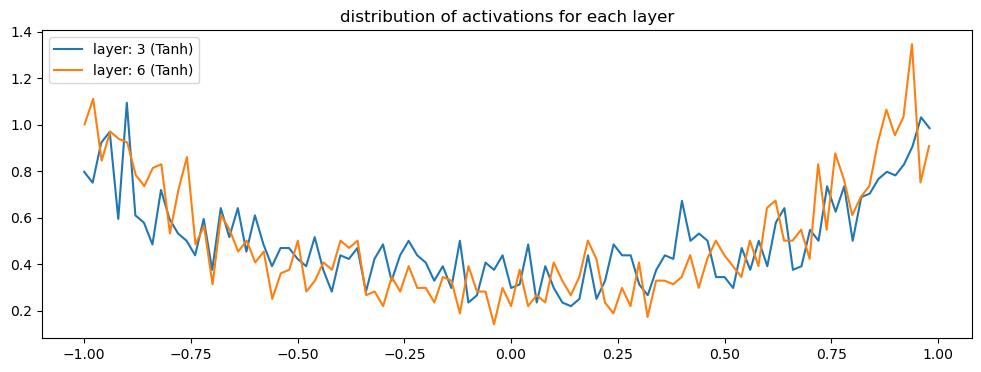

layer: Tanh 	 mean: 0.0 	 std: 0.003148 	
layer: Tanh 	 mean: -0.0 	 std: 0.002839 	


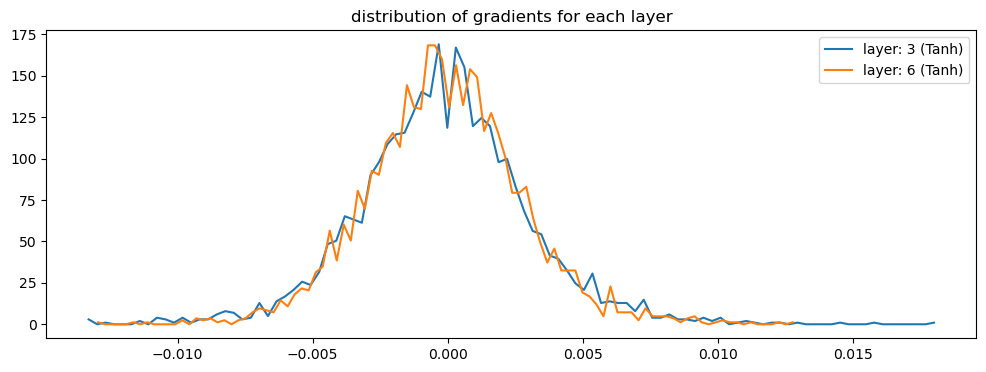

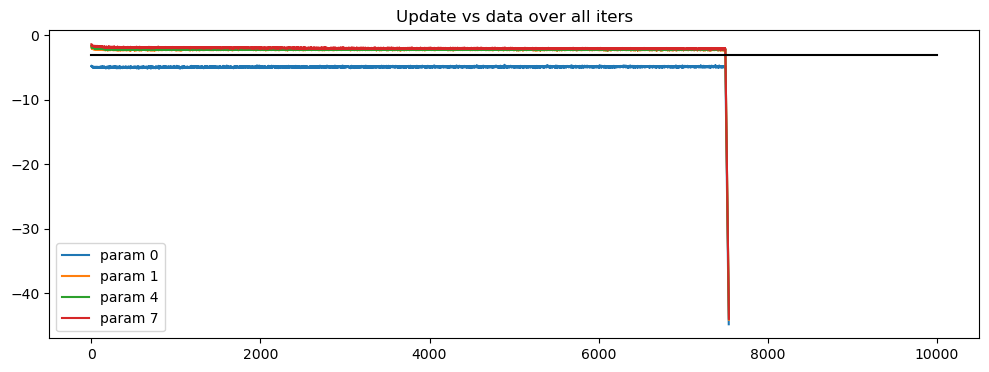

In [76]:
plot_tanh_activations(model)
plot_tanh_grads(model);
plot_update_vs_data(model, ud)


In [77]:

with torch.no_grad():
    y_hat = model(x_val)
    loss = F.cross_entropy(y_hat, y_val)
    print(f"loss (val): {loss}")

loss (val): 2.266145706176758


1. I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [78]:
class Linear:
    def __init__(self, in_dim, out_dim, bias=True, device="cuda"):
        scale = 1 / (in_dim ** (0.5))
        self.w = torch.zeros((in_dim, out_dim)) * scale
        self.b = torch.zeros(out_dim) if bias else None

        

    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        
        return self.out

    def parameters(self):
        params = [self.w] + ([] if self.b is None else [self.b])
        return params

class Embedding:
    def __init__(self, in_dim, out_dim, device="cuda"):
        self.c = torch.zeros((in_dim, out_dim))


    def __call__(self, x):
        self.out = self.c[x]
        return self.out

    def parameters(self):
        return [self.c]


In [79]:
from tqdm import tqdm
    
n_steps=10
batch_size=32
learn_rate=0.1
model_zero = MLP()
grads = []

losses = []
update_vs_data = []

for iter in tqdm(range(n_steps)):
    rand_idx = torch.randint(0, x_train.shape[0], (batch_size, ))
    x_batch, y_batch = x_train[rand_idx], y_train[rand_idx]

    y_hat = model_zero(x_batch)
    loss = F.cross_entropy(y_hat, y_batch)
    losses.append(loss.item())

    for layer in model_zero.layers:
        layer.out.retain_grad()
    model_zero.zero_grad()
    loss.backward()
    
    learn_rate = learn_rate if iter < (3 / 4 * n_steps) else learn_rate / 10
    for idx, p in enumerate(model_zero.parameters()):
        p.data = p.data - learn_rate * p.grad
        if iter == 5:
            grads.append((p.grad, idx))

    with torch.no_grad():
        ud_iter = []
        for p in model_zero.parameters():
            ud = (learn_rate * p.grad).std() / p.data.std()
            ud = ud.log10().item()
            ud_iter.append(ud)

        update_vs_data.append(ud_iter)

print(f"loss (train): {loss.item()}")
     

100%|██████████| 10/10 [00:00<00:00, 132.59it/s]

loss (train): 3.262946844100952


[]

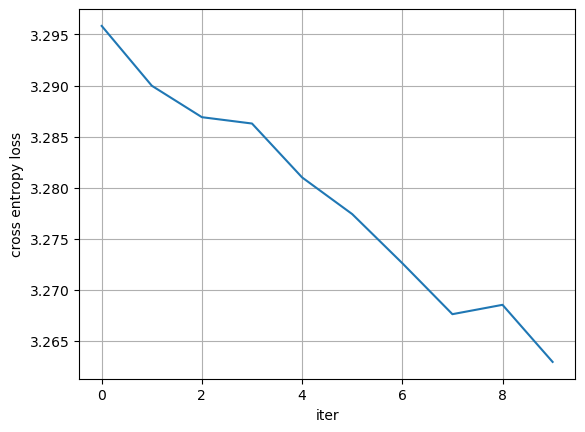

In [80]:

plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("cross entropy loss")
plt.grid()
plt.plot()

In [81]:
for layer in model.layers:
    print(layer.out.grad is None)

True
True
True
True
True
True
True
True
True


layer: Tanh 	 mean: 0.0 	 std: 0.0 	 sat_perc[%]: 0.0
layer: Tanh 	 mean: 0.0 	 std: 0.0 	 sat_perc[%]: 0.0


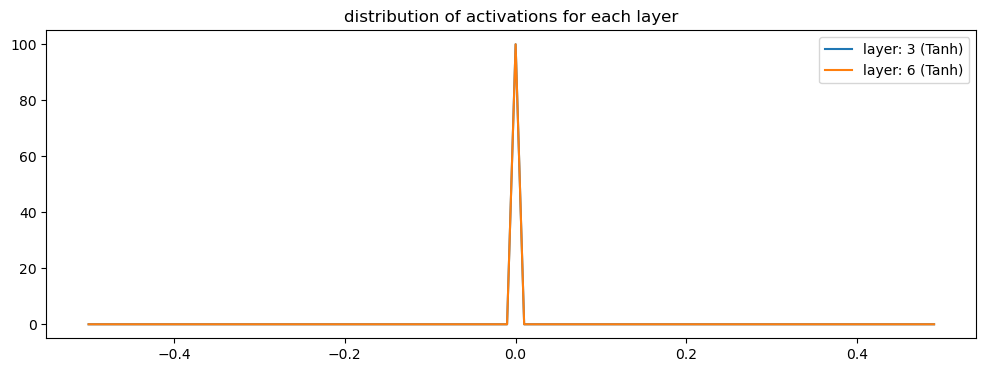

layer: Tanh 	 mean: 0.0 	 std: 0.0 	
layer: Tanh 	 mean: 0.0 	 std: 0.0 	


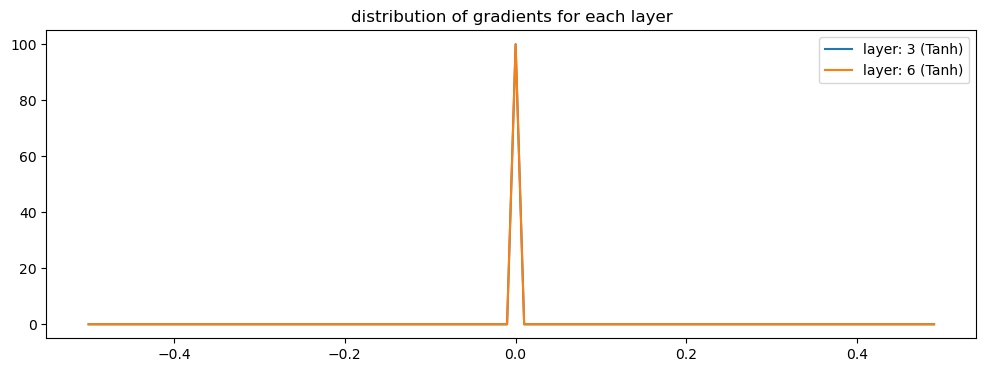

In [82]:
plot_tanh_activations(model_zero)
plot_tanh_grads(model_zero);


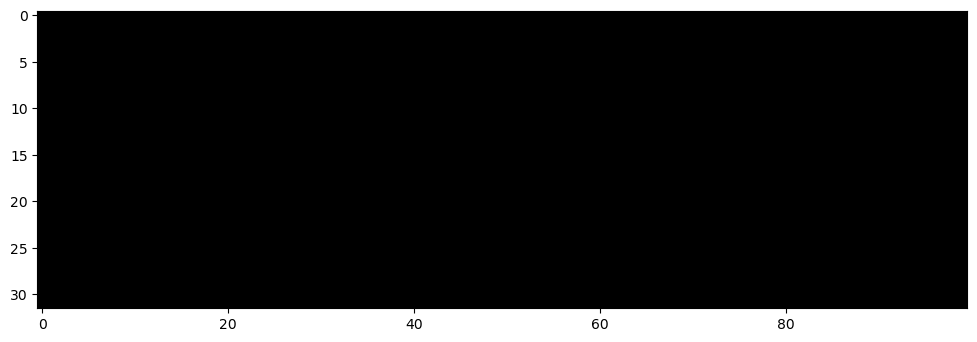

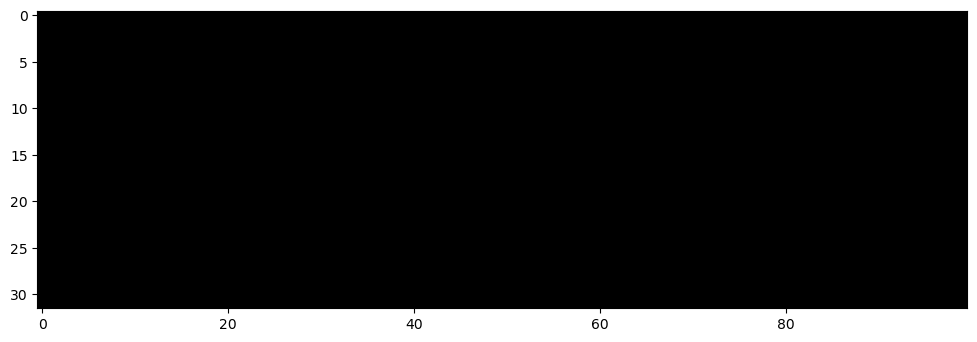

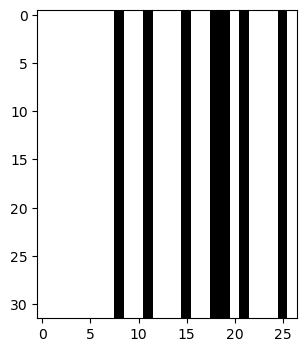

In [83]:
plt.figure(figsize=(12, 4))
c = model_zero.layers[0].c
w1, b1 = model_zero.layers[1].w, model_zero.layers[2].bias
h = torch.tanh(c[x_batch].view(-1, n_embed * block_size) @ w1 + b1)
h = h.to(device="cpu")
h.shape

plt.imshow(h.abs() > 0.01, cmap="gray", interpolation="nearest");


plt.figure(figsize=(12, 4))
c = model_zero.layers[0].c
w1, b1 = model_zero.layers[1].w, model_zero.layers[2].bias
h1 = torch.tanh(c[x_batch].view(-1, n_embed * block_size) @ w1 + b1)
w2, b2 = model_zero.layers[4].w, model_zero.layers[5].bias
h2 = torch.tanh(h1 @ w2 + b2)
h2 = h2.to(device="cpu")

plt.imshow(h2.abs() > 0.01, cmap="gray", interpolation="nearest");

plt.figure(figsize=(12, 4))
c = model_zero.layers[0].c
w1, b1 = model_zero.layers[1].w, model_zero.layers[2].bias
h1 = torch.tanh(c[x_batch].view(-1, n_embed * block_size) @ w1 + b1)
w2, b2 = model_zero.layers[4].w, model_zero.layers[5].bias
h2 = torch.tanh(h1 @ w2 + b2)
w3, b3 = model_zero.layers[7].w, model_zero.layers[8].bias
h3 = h2 @ w3 + b3
h3 = h3.to(device="cpu")

plt.imshow(h3.abs() > 0.01, cmap="gray", interpolation="nearest");

In [84]:
for g in grads:
    if g[0].sum() > 0.0:
        print(f"non zero grad: {g[0]}")
        print(f"param index of non zero grad: {g[1]} / {len(model_zero.parameters())}")

2. BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [89]:
g = torch.Generator().manual_seed(61616161)
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out, generator=g) / fan_in ** (0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps=1e-5):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var 

        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [90]:
m = len(x)

rand_idxs = torch.randperm(m)
x = x[rand_idxs]
y = y[rand_idxs]
n1 = int(0.8 * m)
n2 = int(0.9 * m)

x_train = x[:n1]
y_train = y[:n1]
x_val = x[n1:n2]
y_val = y[n1:n2]
x_test = x[n2:]
y_test = y[n2:]

In [91]:
def create_net(weight_gain = 5 / 3):
    n_embed = 10 
    n_hidden = 100 
    vocab_size = 27

    g = torch.Generator().manual_seed(61616161)
    c = torch.randn((vocab_size, n_embed), generator=g)
    
    layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
    ]

    with torch.no_grad():
        layers[-1].gamma *= 0.1
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 1.0 

    params = [c] + [p for layer in layers for p in layer.parameters()]
    print(f"num params: {sum(p.nelement() for p in params)}")
    for p in params:
        p.requires_grad = True

    return c, layers, params

In [92]:
c, layers, params = create_net()


num params: 16424


In [93]:
def train_net(c, layer, params):
    max_steps = 10000
    batch_size = 32
    lossi = []
    ud = []

    for i in tqdm(range(max_steps)):
        ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
        Xb, Yb = x_train[ix], y_train[ix] 

        emb = c[Xb]
        x = emb.view(emb.shape[0], -1) 
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) 

        for layer in layers:
            layer.out.retain_grad() 
        for p in params:
            p.grad = None
        loss.backward()

        lr = 0.1 if i < 150000 else 0.01 
        for p in params:
            p.data += -lr * p.grad

        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])

    return ud

In [94]:
train_net(c, layer, params)


100%|██████████| 10000/10000 [00:14<00:00, 704.31it/s]


[[-3.8434362411499023,
  -2.8602988719940186,
  1.604900353413541e-05,
  0.0,
  -2.6857707500457764,
  -1.6644997231196612e-05,
  0.0,
  -2.4904308319091797,
  5.1771934295175015e-08,
  0.0],
 [-3.8424627780914307,
  -2.822559118270874,
  -0.1320524662733078,
  -0.14338022470474243,
  -2.6368372440338135,
  -0.1510874181985855,
  -0.0743270069360733,
  -2.421661853790283,
  -0.3535754084587097,
  -0.3397945761680603],
 [-3.8223984241485596,
  -2.880943536758423,
  -0.24918419122695923,
  -0.26562830805778503,
  -2.6707212924957275,
  -0.24929802119731903,
  -0.265960693359375,
  -2.4406378269195557,
  -0.2723143696784973,
  -0.4682268500328064],
 [-3.7417869567871094,
  -2.8162479400634766,
  -0.18814313411712646,
  -0.28129833936691284,
  -2.6158878803253174,
  -0.3954269289970398,
  -0.3127000331878662,
  -2.421919107437134,
  -0.4632768929004669,
  -0.5472757816314697],
 [-3.8998849391937256,
  -2.896902084350586,
  -0.39250367879867554,
  -0.393216073513031,
  -2.698864459991455,
 

In [95]:

@torch.no_grad() 
def split_loss(split):
  x,y = {
    'train': (x_train, y_train),
    'val': (x_val, y_val),
    'test': (x_test, y_test),
  }[split]
  emb = c[x] 
  x = emb.view(emb.shape[0], -1) 
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.2230942249298096
val 2.2427773475646973


In [96]:
with torch.no_grad():
    layers[0].weight *= (layers[1].gamma / torch.sqrt(layers[1].running_var))
    layers[3].weight *= (layers[4].gamma / torch.sqrt(layers[4].running_var))
    layers[6].weight *= (layers[7].gamma / torch.sqrt(layers[7].running_var))
    layers[0].bias = - ((layers[1].gamma * layers[1].running_mean) / torch.sqrt(layers[1].running_var)) + layers[1].beta
    layers[3].bias = - ((layers[4].gamma * layers[4].running_mean) / torch.sqrt(layers[4].running_var)) + layers[4].beta
    layers[6].bias = - ((layers[7].gamma * layers[7].running_mean) / torch.sqrt(layers[7].running_var)) + layers[7].beta
     

In [97]:
new_layers = []

for layer in layers:
    if not isinstance(layer, BatchNorm1d):
        new_layers.append(layer)

for layer in new_layers:
    print(layer.__class__.__name__)

Linear
Tanh
Linear
Tanh
Linear


In [98]:
@torch.no_grad() 
def split_loss(split):
  x,y = {
    'train': (x_train, y_train),
    'val': (x_val, y_val),
    'test': (x_test, y_test),
  }[split]
  emb = c[x] 
  x = emb.view(emb.shape[0], -1) 
  for new_layer in new_layers:
    x = new_layer(x)

  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('val')

val 2.2427773475646973
